<a href="https://www.kaggle.com/code/danielfourie/ps4e2-obesity-risk-advanced-eda-xgboost?scriptVersionId=206201186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
# Filter all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cdc-bmi-age2-20-percentiles-boys-and-girls/CDC_BMI_Age2-20_Percentiles_Girls.csv
/kaggle/input/cdc-bmi-age2-20-percentiles-boys-and-girls/CDC_BMI_Age2-20_Percentiles_Boys.csv
/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


<center>
    <h1>Playground Series S4E2 - Obesity Risk</h1>
    <img src="https://www.heart.org/-/media/Images/News/2022/January-2022/0112BHObesityBrain_SC.jpg">
</center>

# <u><b>Data Reading and Cleaning</b></u>

In [2]:
#import datasets
dataset = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
dataset_test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")

In [3]:
#Let's look at top 5 rows
dataset.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**We notice the id column is the same as our index.**

In [4]:
#Let's see the shape of our dataset
dataset.shape

(20758, 18)

**Let's see how many null values we have in dataset and dataset_test.**

In [5]:
dataset_nans = dataset.isnull().sum().to_frame().T
dataset_nans['DataFrame'] = 'dataset'
dataset_test_nans = dataset_test.isnull().sum().to_frame().T
dataset_test_nans['DataFrame'] = 'dataset_test'
combined_df = pd.concat([dataset_nans, dataset_test_nans], axis=0, ignore_index=True)
combined_df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,DataFrame
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,dataset
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,dataset_test


**We have no null values in both datasets. This is great!**

In [6]:
#Set id to index
dataset.set_index('id',inplace=True)
dataset_test.set_index('id',inplace=True)
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**Let's look at the columns and their data type for both datasets.**

In [7]:
dataset_nans = dataset.dtypes.to_frame().T
dataset_nans['DataFrame'] = 'dataset'
dataset_test_nans = dataset_test.dtypes.to_frame().T
dataset_test_nans['DataFrame'] = 'dataset_test'
combined_df = pd.concat([dataset_nans, dataset_test_nans], axis=0, ignore_index=True)
combined_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,DataFrame
0,object,float64,float64,float64,object,object,float64,float64,object,object,float64,object,float64,float64,object,object,object,dataset
1,object,float64,float64,float64,object,object,float64,float64,object,object,float64,object,float64,float64,object,object,NaN,dataset_test


**The dtype of each feature matches across both datasets. We will now see if each feature in dataset has the same number of unique values in dataset_test.<br>This is important as if we have any object features that have more unique values in dataset_test than dataset then we will need to accomodate for this in order to build a machine learning model that can handle dataset_test for the submission.**

In [8]:
#Let's see what the unique values are for all object columns.
#We know from the data description in the competition that NObeyesdad will have at least 3 values
dataset_features_unique_vals_dict = {}
dataset_test_features_unique_vals_dict = {}
for data in [dataset,dataset_test]:
    for col in data.columns:
        if dataset[col].dtype == 'O':
            if 'NObeyesdad' in data.columns.tolist():
                dataset_features_unique_vals_dict[col] = data[col].nunique()
            else:
                dataset_test_features_unique_vals_dict[col] = data[col].nunique()
dataset_features_unique_vals_dict['DataFrame'] = 'dataset'
dataset_test_features_unique_vals_dict['DataFrame'] = 'dataset_test'
combined_df = pd.DataFrame([dataset_features_unique_vals_dict, dataset_test_features_unique_vals_dict])
combined_df

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad,DataFrame
0,2,2,2,4,2,2,3,5,7.0,dataset
1,2,2,2,4,2,2,4,5,NaN,dataset_test


**We see we have an issue. The feature CALC has 3 unique values in dataset and one more in our dataset_test.<br>
Let's see which value dataset is missing.**

In [9]:
print(f"Dataset's unique values in feature CALC: {dataset.CALC.unique().tolist()}".replace("[","").replace("]",""))
print(f"Dataset_test's unique values in feature CALC: {dataset_test.CALC.unique().tolist()}".replace("[","").replace("]",""))

Dataset's unique values in feature CALC: 'Sometimes', 'no', 'Frequently'
Dataset_test's unique values in feature CALC: 'Sometimes', 'no', 'Frequently', 'Always'


**To address this we will add a column to the training dataset called CALC_Always and assign it to only have values of 0. This will represent that in the training dataset there were no records where CALC had the value of 'Always'.**

In [10]:
dataset['CALC_Always'] = 0

**Moving on, we are dealing with a multi-classification problem - specifically 7 classes. Because the number of unique values is not high, let's have a look at each column's unique values.**

In [11]:
#Each object column's unique values
for col in dataset.columns:
    if dataset[col].dtype == 'O':
        print(f"{col}'s values: {dataset[col].unique().tolist()}".replace("[","").replace("]",""))

Gender's values: 'Male', 'Female'
family_history_with_overweight's values: 'yes', 'no'
FAVC's values: 'yes', 'no'
CAEC's values: 'Sometimes', 'Frequently', 'no', 'Always'
SMOKE's values: 'no', 'yes'
SCC's values: 'no', 'yes'
CALC's values: 'Sometimes', 'no', 'Frequently'
MTRANS's values: 'Public_Transportation', 'Automobile', 'Walking', 'Motorbike', 'Bike'
NObeyesdad's values: 'Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', 'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_I'


**From our findings above we have the following types of independent features:<br>
Categorical: Gender, family_history, FAVC, CAEC, SMOKE, SCC, CALC, and MTRANS<br>
Numerical: Age, Height, Weight, FCVC, NCP, CH20, FAF, and TUE<br>
We will now move onto some EDA.**

# <u><b>Exploratory Data Analysis (EDA)</b></u>

In [12]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns

**Let's look at a histogram for each numerical feature.**

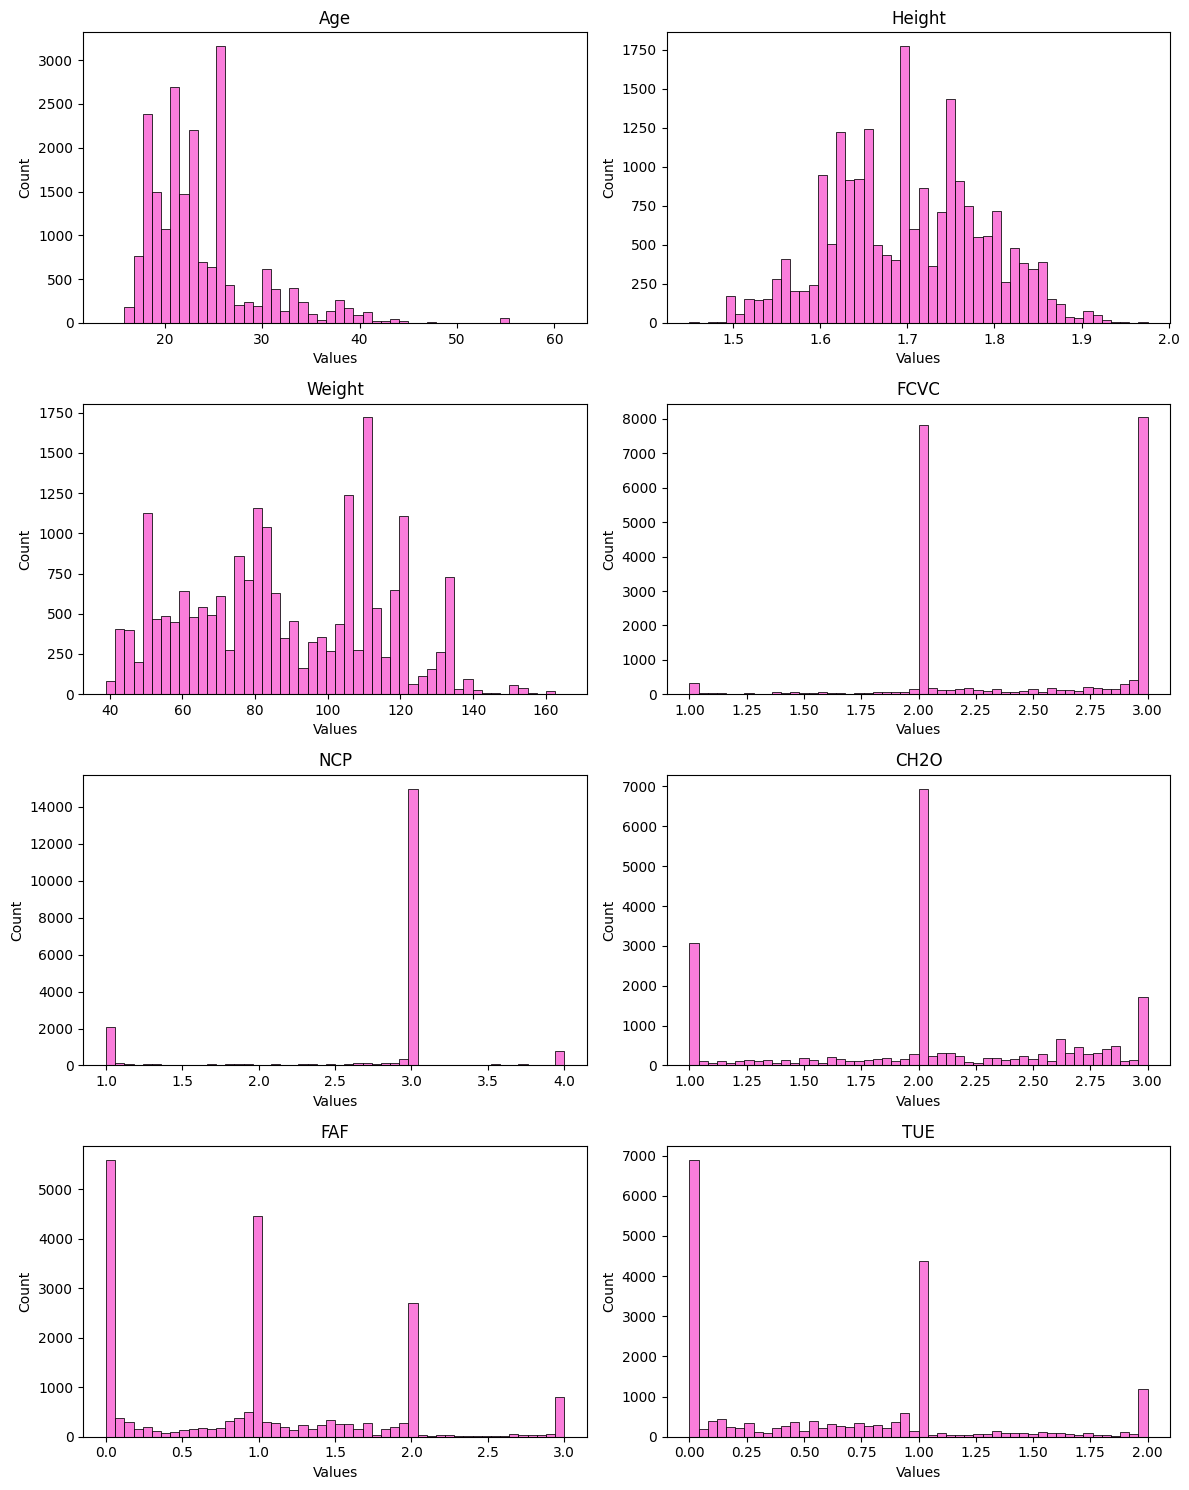

In [13]:
numeric_features = dataset.select_dtypes(include=['float64'])
#Plotting the histograms
fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(12, 15))
plt.style.use('seaborn-v0_8-whitegrid')
#Flatten the 2D array of axes for easy indexing
axs = axs.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(data=dataset, x=feature, ax=axs[i], color='#f951d0', bins=50)
    axs[i].set_xlabel('Values')
    axs[i].set_title(feature)
    
plt.tight_layout()
plt.show()

**We notice that Age is skewed to the right - we will later perform a transformation to make the distribution more normal.<br>
Height has a fairly normal distribution, while Weight is slightly skewed to the left for most of the values but it does contain a big spike near the right side of the median. We will also perform a transformation on this feature.<br>All the other numerical features are spread out with the occasional big spike. We do however see that FAF and TUE follow a similar trajectory.**

**We can deduce that the feature CH2O is the daily consumption of water per person in litres. Let's find out more about this feature in our dataset.**

Analysis of feature CH2O
count    20758.000000
mean         2.029418
std          0.608467
min          1.000000
25%          1.792022
50%          2.000000
75%          2.549617
max          3.000000
Name: CH2O, dtype: float64


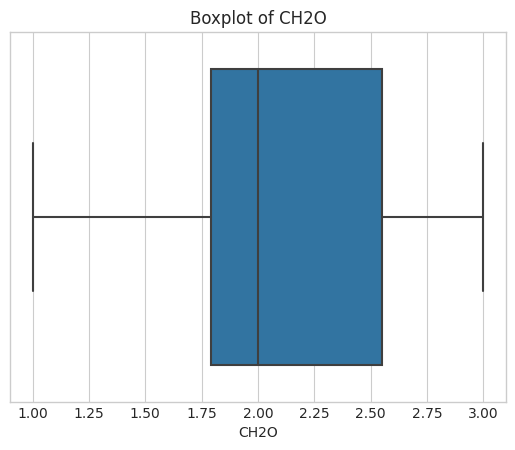

In [14]:
print("Analysis of feature CH2O")
print(dataset['CH2O'].describe())
sns.boxplot(data=dataset,x='CH2O')
plt.title('Boxplot of CH2O')
plt.show()

**Let's see the distributions of our independent categorical features.**

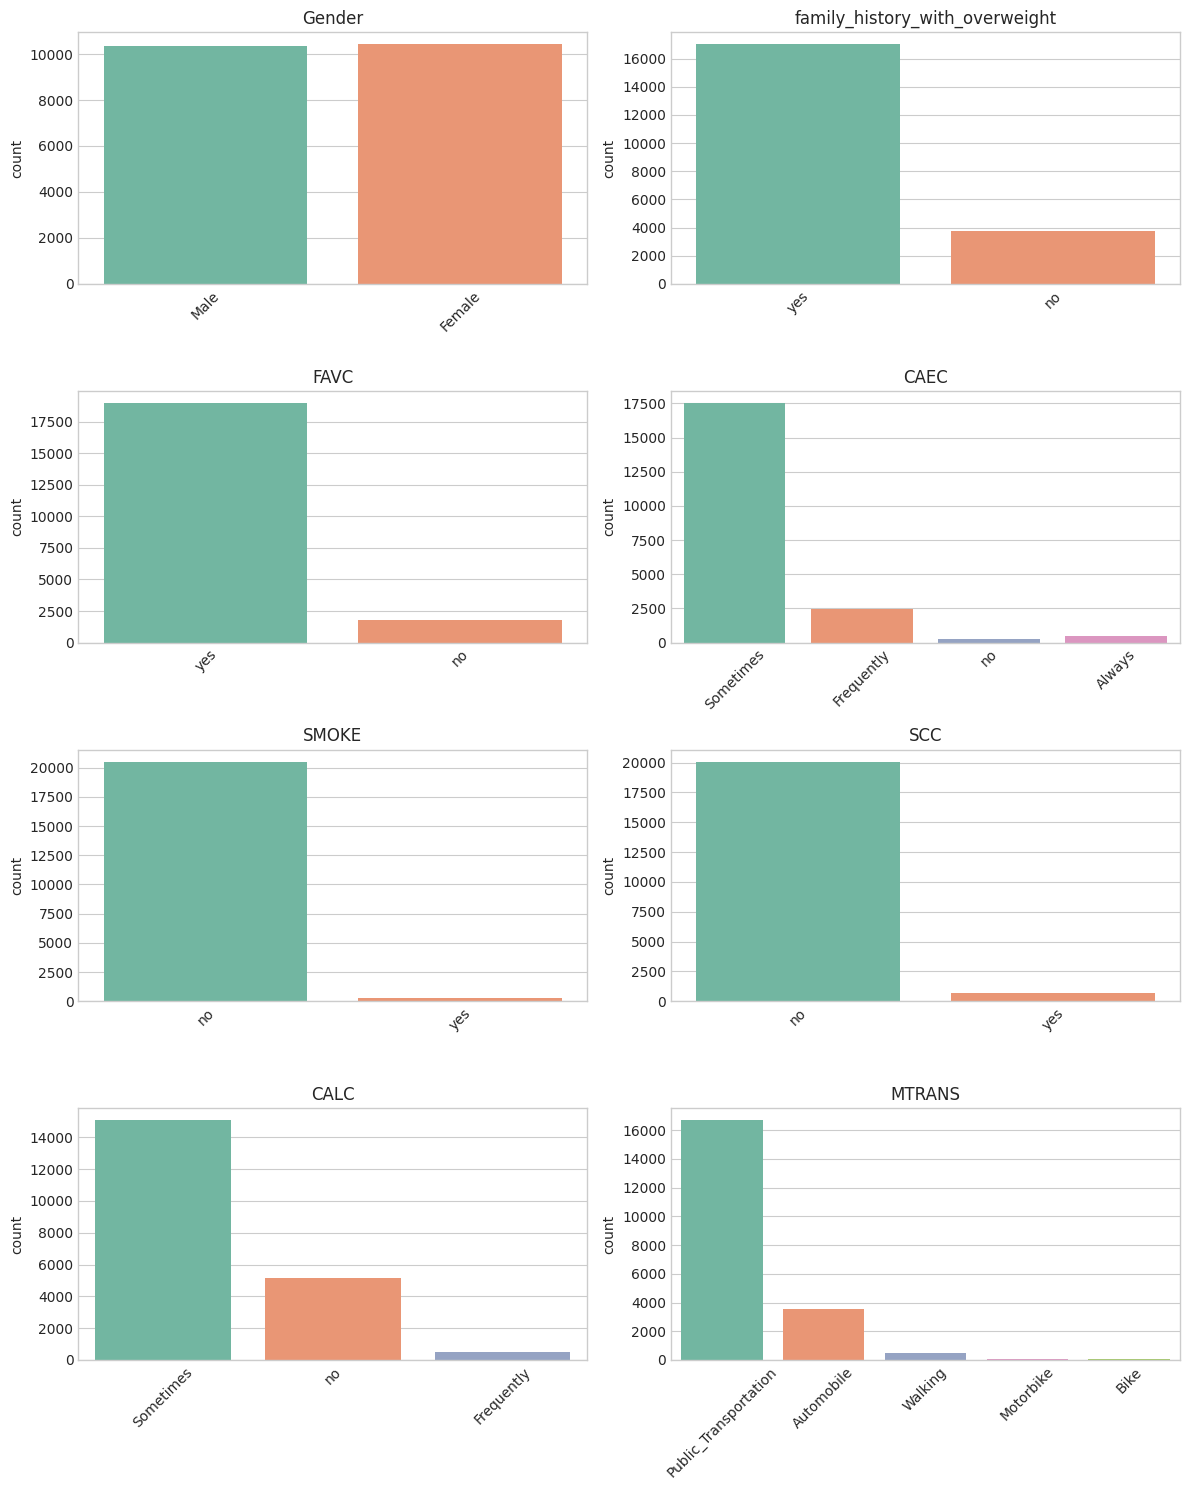

In [15]:
categorical_features = dataset.select_dtypes(include=['O']).columns.tolist()
categorical_features.remove('NObeyesdad')
#Plotting the pie plots
fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(12, 15))
#Flatten the 2D array of axes for easy indexing
axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=dataset,x=feature,ax=axs[i],palette='Set2')
    axs[i].set_xticklabels(labels=axs[i].get_xticklabels(), rotation=45)
    axs[i].set_xlabel('')
    axs[i].set_title(feature)
    
plt.tight_layout()
plt.show()

**We notice a big disparity in terms of the number of people who smoke and who do not. The same goes for the feature SCC (Self-Care Commitment).<br>Because the large majority of people take the public transport as their mode of transportation we will now look further into the MTRANS feature by seeing the distribution of the weight classification.**

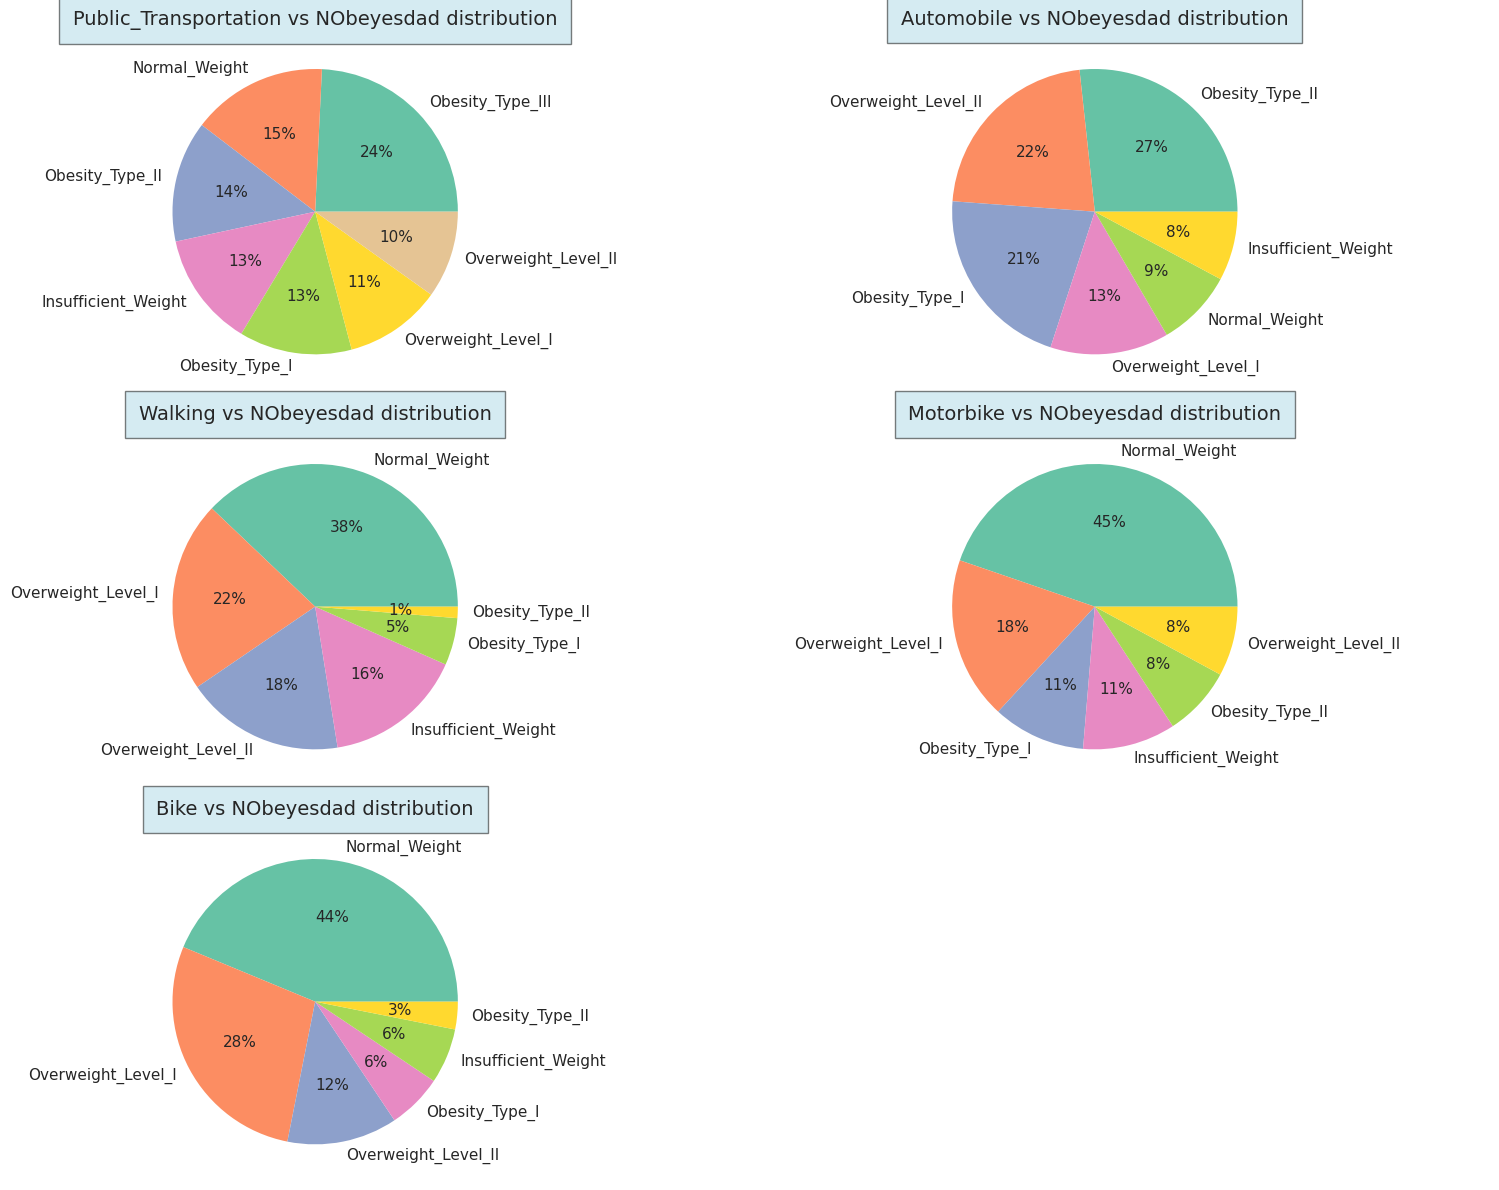

In [16]:
public_trans = dataset[dataset.MTRANS == 'Public_Transportation'].NObeyesdad.value_counts()
automobile_trans = dataset[dataset.MTRANS == 'Automobile'].NObeyesdad.value_counts()
walking_trans = dataset[dataset.MTRANS == 'Walking'].NObeyesdad.value_counts()
motorbike_trans = dataset[dataset.MTRANS == 'Motorbike'].NObeyesdad.value_counts()
bike_trans = dataset[dataset.MTRANS == 'Bike'].NObeyesdad.value_counts()

#Create subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
axs = axs.flatten() #flatten the 2D array of axes for easy indexing

features = [public_trans, automobile_trans, walking_trans, motorbike_trans, bike_trans]
feature_values = ['Public_Transportation','Automobile','Walking','Motorbike','Bike']

for i, feature in enumerate(features):
    axs[i].pie(x=feature.values, labels=feature.index, colors=sns.color_palette('Set2'), autopct='%.0f%%', textprops={'fontsize': 11})
    axs[i].set_title(f'{feature_values[i]} vs NObeyesdad distribution', fontsize=14, bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 10})

axs[-1].axis('off') #Set the last subplot to be blank
plt.tight_layout()
plt.show()

**While public transportion is fairly evenly distributed, which would indicate that it could not be of great use for prediction, and it comprises of about 80% of the feature, the other modes of transportation are not evenly distributed at all and therefore we will be keeping MTRANS as the nuances between the modes of transport may give good insight for our model.**

**We will now determine whether SCC brings in enough insight by seeing its distribution against our target variable.**

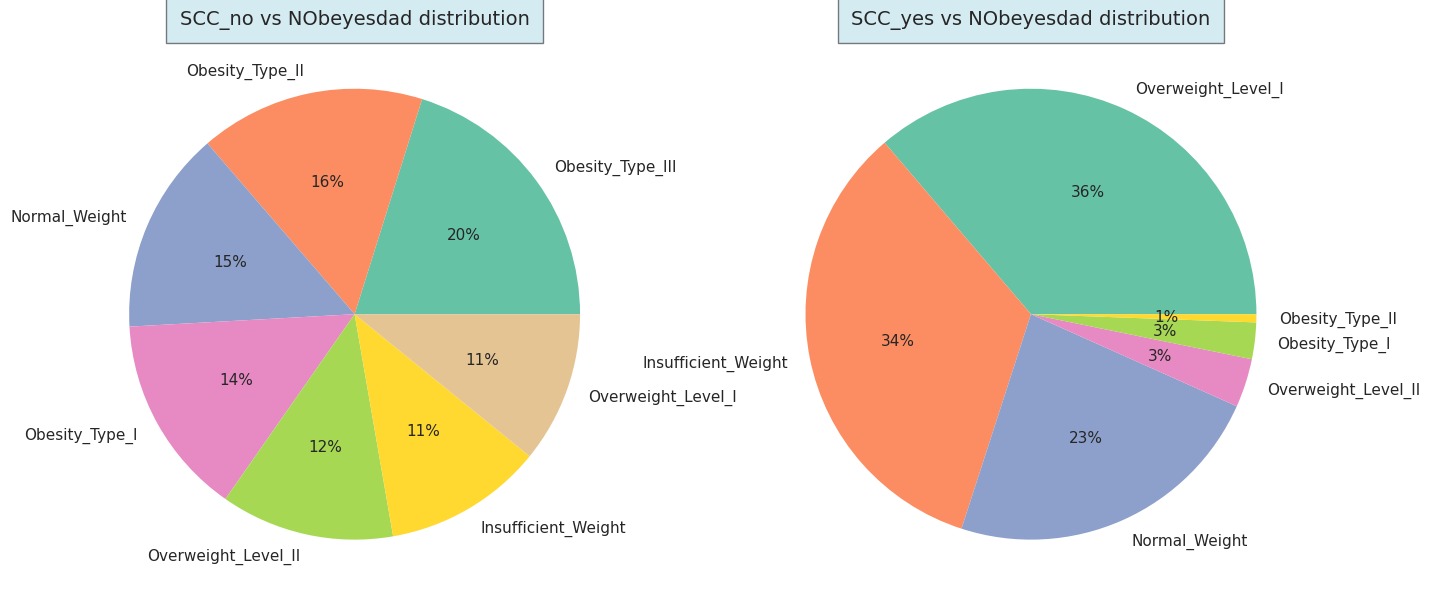

In [17]:
SCC_no = dataset[dataset.SCC == 'no']['NObeyesdad'].value_counts()
SCC_yes = dataset[dataset.SCC == 'yes']['NObeyesdad'].value_counts()
feature_values = ['SCC_no','SCC_yes']
#Create subplots
fig, axs = plt.subplots(1,2,figsize=(16, 12))
axs = axs.flatten()
for i, feature in enumerate([SCC_no,SCC_yes]):
    axs[i].pie(x=feature.values, labels=feature.index, colors=sns.color_palette('Set2'), autopct='%.0f%%', textprops={'fontsize': 11})
    axs[i].set_title(f'{feature_values[i]} vs NObeyesdad distribution', fontsize=14, bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 10})

**We can infer from these results that the feature SCC will not be of much use to us as a feature on its own considering that SCC_yes only contributes about 3% of the data, and SCC_no is quite evenly distributed.**

**Let's now see the distribution of our target feature NObeyesdad.**

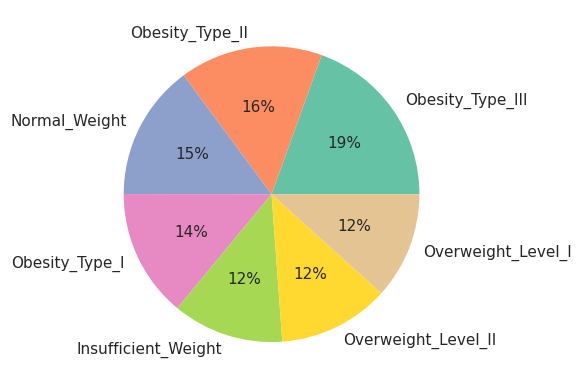

In [18]:
temp_series = dataset['NObeyesdad'].value_counts()
plt.pie(x=temp_series, labels=temp_series.index, colors=sns.color_palette('Set2'), autopct='%.0f%%', textprops={'fontsize': 11});

**We notice a relatively balanced distribution across all classes, with Obesity_Type_III being the highest (19%). This is good as there will not likely be a bias towards any class during model training for prediction.**

# <u><b>Feature Engineering and Data Preparation</b></u>

**As we know if one treats their body well, i.e. does self-care, then their gains from physical activities will increase. For this reason, if SCC is a yes, then we will increase that person's FAF score by 10%.**

In [19]:
dataset['FAF'] = dataset.apply(lambda row: row['FAF']*1.1 if row['SCC']=='yes' else row['FAF'],axis=1)

**Conversely, if a person smokes then their gains from physical activities will decrease. Therefore, if a person smokes we will decrease their FAF score by 5%.**

In [20]:
dataset['FAF'] = dataset.apply(lambda row: row['FAF']*0.95 if row['SMOKE']=='yes' else row['FAF'],axis=1)

**We will now perform multiple transformations on the Age feature to see which is the best one, but first let's see the skewness value of Age.**

In [21]:
dataset.Age.skew()

1.5862517094133515

**This value aligns with our visualisation from before were we noticed that Age is skewed to the right.**

In [22]:
#Transformations on Age
#BoxCox transformation on Age
from scipy.stats import boxcox, yeojohnson
dataset['Age_BoxCox'], boxcox_lambda_value_Age = boxcox(dataset['Age'])
#YeoJohnson transformation on Age
dataset['Age_YJ'], yj_lambda_value_Age = yeojohnson(dataset['Age'])
#Log transformation on Age
dataset['Age_Log'] = np.log(dataset['Age'])
#Recipricol transformation on Age
dataset['Age_Recip'] = (1/dataset['Age'])

**Let's view the distrubitions of Age for each transformation.**

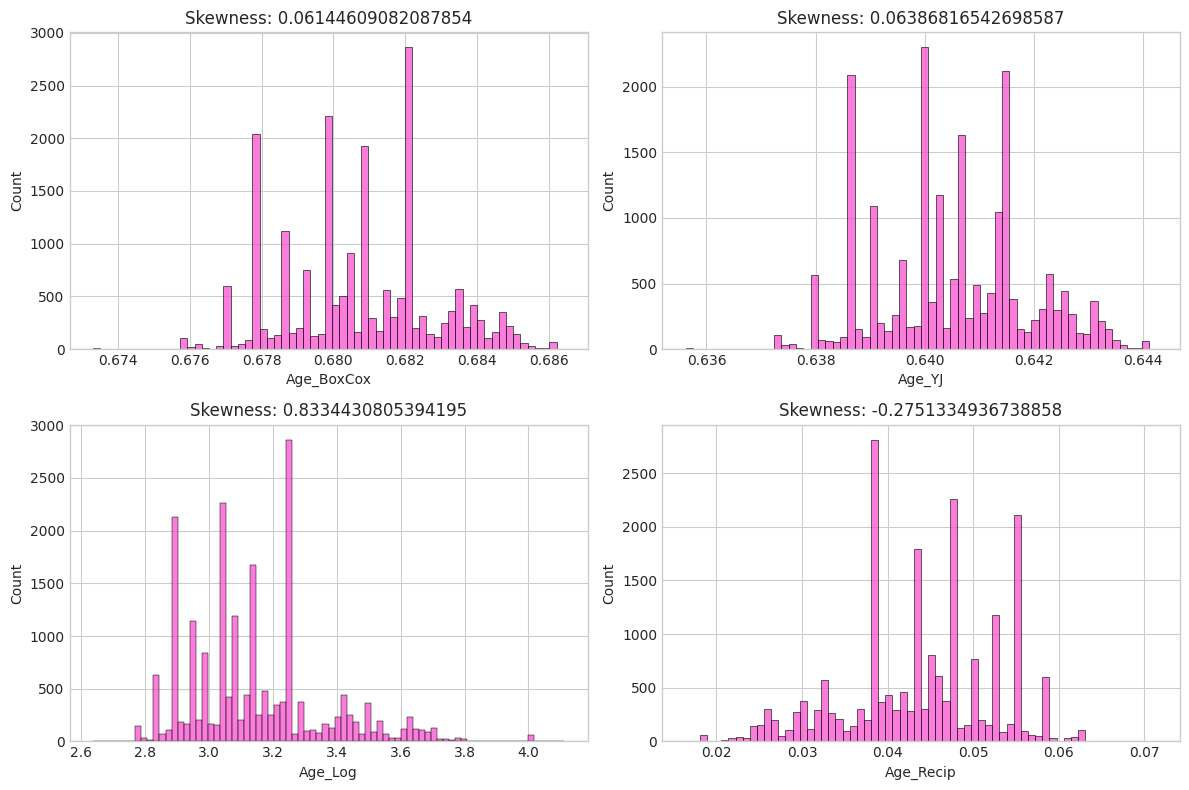

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid')
#Flatten the 2D array of axes for easy indexing
axs = axs.flatten()
transformation_features = ['Age_BoxCox','Age_YJ','Age_Log','Age_Recip']

for i, feature in enumerate(transformation_features):
    sns.histplot(data=dataset,x=feature,ax=axs[i],color='#f951d0')
    axs[i].set_xlabel(feature)
    axs[i].set_title(f'Skewness: {dataset[feature].skew()}')

plt.tight_layout()
plt.show()

**We see BoxCox and YeoJohnson transformations performed best in terms of getting a normal distribution. Since the BoxCox transformation has the best skewness value (although very close to YeoJohnson) we will later replace Age with BoxCox(Age) as we will need the original Age for our BMI related features we will create. For now, we will drop all other created Age features.**

In [24]:
dataset['Age'] = dataset['Age_BoxCox']
dataset.drop(transformation_features,axis=1,inplace=True)
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,CALC_Always
id,,,,,,,,,,,,,,,,,,
0,Male,0.681558,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,0
1,Female,0.677854,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,0
2,Female,0.677854,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0
3,Female,0.679898,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,0
4,Male,0.683627,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,0


**We will now do the same with the feature Weight.**

Skewness of Weight before transformation: 0.09318727954173465



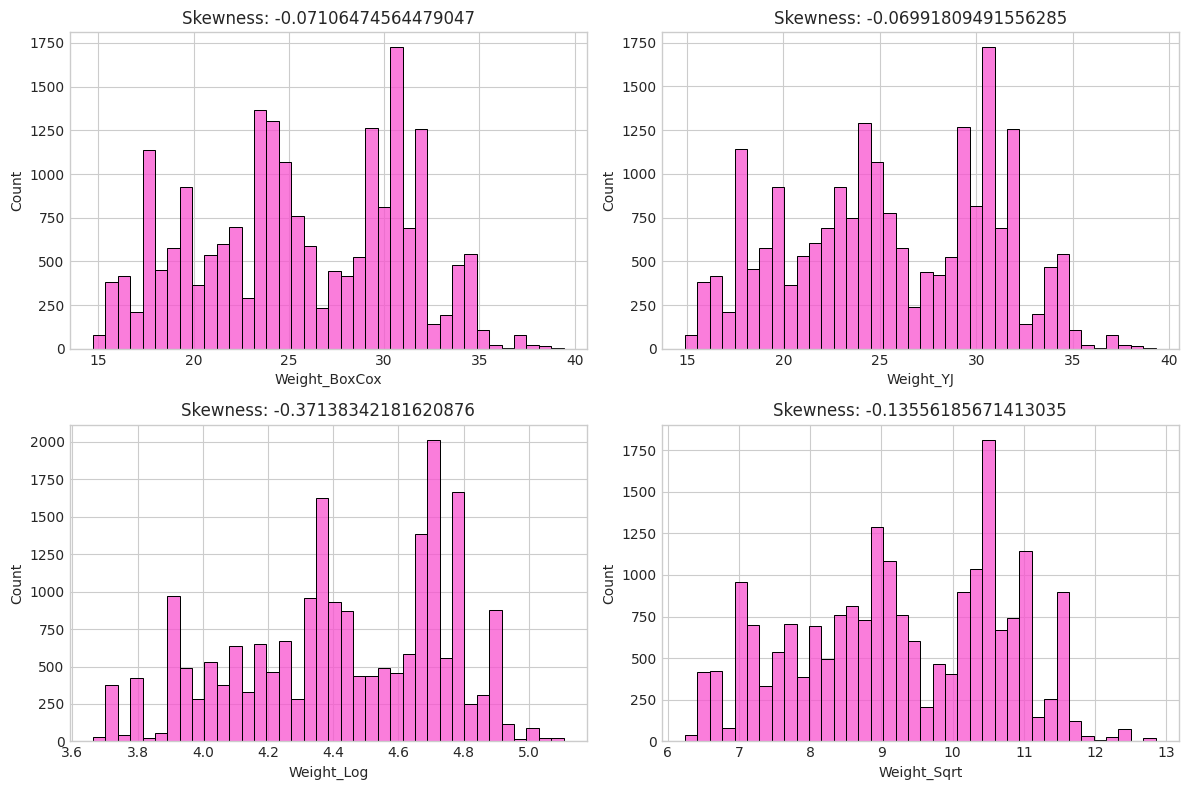

In [25]:
#Weight skewness beform transformations
print(f"Skewness of Weight before transformation: {dataset.Weight.skew()}\n")
#Transformations on Weight
#BoxCox transformation on Weight
dataset['Weight_BoxCox'], boxcox_lambda_value_Weight = boxcox(dataset['Weight'])
#YeoJohnson transformation on Weight
dataset['Weight_YJ'], yj_lambda_value_Weight = yeojohnson(dataset['Weight'])
#Log transformation on Weight
dataset['Weight_Log'] = np.log(dataset['Weight'])
#Square-root transformation on Weight
dataset['Weight_Sqrt'] = np.sqrt(dataset['Weight'])

#Plotting histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid')
axs = axs.flatten()
transformation_features = ['Weight_BoxCox','Weight_YJ','Weight_Log','Weight_Sqrt']

for i, feature in enumerate(transformation_features):
    sns.histplot(data=dataset,x=feature,ax=axs[i],color='#f951d0')
    axs[i].set_xlabel(feature)
    axs[i].set_title(f'Skewness: {dataset[feature].skew()}')

plt.tight_layout()
plt.show()

**We see BoxCox and YeoJohnson transformations yet again performed best in terms of getting a normal distribution. Since the YeoJohnson transformation has the best skewness value (although very close to BoxCox) we will replace Weight with YeoJohnson(Age) and drop all other created Weight features. While the skewness value has not increased dramatically after the YJ transformation we do visually see that there is less of an issue with the spikes as opposed to before. This is good.**

In [26]:
dataset['Weight'] = dataset['Weight_YJ']
dataset.drop(transformation_features,axis=1,inplace=True)
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,CALC_Always
id,,,,,,,,,,,,,,,,,,
0,Male,0.681558,1.699998,24.613856,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,0
1,Female,0.677854,1.560000,19.317917,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,0
2,Female,0.677854,1.711460,17.713211,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0
3,Female,0.679898,1.710730,33.763601,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,0
4,Male,0.683627,1.914186,27.001969,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,0


**We will now create a feature called PhysicalActivityBenefit = FAF - TUE, i.e. Physical activity frequency - Time using technological devices. The reason why we are subtracting TUE from FAF is because when a person spends a lot of their time on technological devices it can lead to them not obtaining the optimal benefits from their physical activities, e.g. staying up late on one's phone and not getting adequate sleep.**

In [27]:
dataset['PhysicalActivityBenefit'] = dataset.FAF - dataset.TUE

**We will also create the feature BMI (body mass index) as this has been a longstanding universal metric for weight classification.**

In [28]:
dataset['BMI'] = dataset.Weight/(dataset.Height**2)

**Due to the previously mentioned disparity of the SMOKE feature, and issue with feature SCC we will drop them from our dataset.**

In [29]:
dataset.drop(['SMOKE','SCC'],axis=1, inplace=True)

**Let's now change columns to be of correct dtype**

In [30]:
#For all categorical features that have two unique values we will encode the feature to be of type int
#we will also encode our target column to be of type int
#keep in mind that our submission requires the prediction to be in original form (before encoding)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_data = dataset.NObeyesdad.values
for colName in dataset.select_dtypes(include=['O']).columns.tolist():
    if dataset[colName].nunique() == 2 or colName == 'NObeyesdad':
        dataset[colName] = label_encoder.fit_transform(dataset[colName])
        if colName == 'NObeyesdad':
            #Create a mapping dictionary to use later for decoding
            label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    else:
        dataset[colName] = dataset[colName].astype('category')

dataset.dtypes

Gender                               int64
Age                                float64
Height                             float64
Weight                             float64
family_history_with_overweight       int64
FAVC                                 int64
FCVC                               float64
NCP                                float64
CAEC                              category
CH2O                               float64
FAF                                float64
TUE                                float64
CALC                              category
MTRANS                            category
NObeyesdad                           int64
CALC_Always                          int64
PhysicalActivityBenefit            float64
BMI                                float64
dtype: object

In [31]:
#We now need to standardise the numeric features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
numeric_features = numeric_features.columns.tolist()
numeric_features.extend(['PhysicalActivityBenefit','BMI'])
dataset[numeric_features] = sc.fit_transform(dataset[numeric_features])
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,CALC_Always,PhysicalActivityBenefit,BMI
id,,,,,,,,,,,,,,,,,,
0,1,0.392392,-0.002828,-0.180944,1,1,-0.836279,0.314684,Sometimes,1.206594,-1.169070,0.597438,Sometimes,Public_Transportation,6,0,-1.311579,-0.190265
1,0,-1.380239,-1.606291,-1.189908,1,1,-0.836279,0.338364,Frequently,-0.048349,0.017443,0.636513,no,Automobile,1,0,-0.359381,-0.538722
2,0,-1.380239,0.128451,-1.495630,1,1,-1.060332,-1.913423,Sometimes,-0.195644,-0.141497,1.755239,no,Public_Transportation,0,0,-1.146845,-1.676721
3,0,-0.402071,0.120090,1.562234,1,1,1.039171,0.338364,Sometimes,-0.584035,0.572568,0.271455,Sometimes,Public_Transportation,4,0,0.311188,1.627414
4,1,1.382593,2.450367,0.274031,1,1,0.438397,-1.119801,Sometimes,-0.081469,1.165955,0.523111,Sometimes,Public_Transportation,6,0,0.651110,-0.881015


**We now need to encode our independent categorical features with more than two unique values.**

In [32]:
categorical_features = dataset.select_dtypes(include='category').columns.tolist()
dataset = pd.get_dummies(data=dataset,columns=categorical_features, drop_first=False, dtype='int')

In [33]:
#Let's get our y (dependant variable) and drop it from the dataset
target_column = dataset.pop('NObeyesdad')

In [34]:
#Splitting datasets into the Training set (80%), and Test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, target_column, test_size = 0.2, random_state = 0)

**We will now implement a machine learning model for prediction on this problem.**

# <u><b>Building and training the model</b></u>

In [35]:
#Import libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,make_scorer,classification_report
#Define F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

<h3><b><i><u>Decison Tree (XGBoost)</u></i></b></h3>

In [36]:
from xgboost import XGBClassifier

**The optuna hyperparameterization code cell below is commented out because it takes long to run. I have used the hyperparameter values from the best trial of the search in order to create the XGBClassifier Model below.**

In [37]:
'''#Create cv strategy
cvStratKFold = StratifiedKFold(5, shuffle=True, random_state=42)
def objective(trial):
    trial_number = trial.number
    print(f'Trial {trial_number+1} in progress')
    # Define the hyperparameters to be optimized
    params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class': 7,
        'eval_metric': 'merror',
        'n_estimators': trial.suggest_int('n_estimators', 100,300),
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-9, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0,log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True)
    }

    # Create an XGBoost Classifier
    xgbModel = XGBClassifier(**params)

    # Evaluate the model using accuracy with cross validation
    scores = cross_val_score(estimator=xgbModel,X=X_train,y=y_train,scoring='accuracy',cv=cvStratKFold)
    accuracy = np.mean(scores)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)
trial = study.best_trial

# Print the best hyperparameters
print(f"Best accuracy: {trial.value}")
print(f"Best hyperparameters: {trial.params}")

best_params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'merror',
    'n_estimators': trial.params['n_estimators'],
    'min_split_loss': trial.params['min_split_loss'],
    'learning_rate': trial.params['learning_rate'],
    'max_depth': trial.params['max_depth'],
    'subsample': trial.params['subsample'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_lambda': trial.params['reg_lambda'],
    'reg_alpha': trial.params['reg_alpha']
}''';

In [38]:
best_params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'merror',
    'n_estimators': 235,
    'min_split_loss': 0.08599260691424013,
    'learning_rate': 0.0567248810160126,
    'max_depth': 9,
    'subsample': 0.9863907947703492,
    'colsample_bytree': 0.3378626948499556,
    'min_child_weight': 10,
    'reg_lambda': 0.010169755101075147,
    'reg_alpha': 2.1888900002466063e-08
}

In [39]:
xgbModel = XGBClassifier(**best_params)
xgbModel.fit(X_train,y_train)

# Make predictions on the train set
y_pred_train = xgbModel.predict(X_train)
# Make predictions on the test set
y_pred_test = xgbModel.predict(X_test)

In [40]:
#Displaying model's performance on Train and Test set
print("Decision Tree (XGBoost) Model's performance on Train, and Test set:")
print(f"The model's accuracy on the training set is: {accuracy_score(y_train,y_pred_train)}")
print(f"The model's accuracy on the test set is: {accuracy_score(y_test,y_pred_test)}\n")
print(f"The model's classification report on the test set\n {classification_report(y_test,y_pred_test)}")

Decision Tree (XGBoost) Model's performance on Train, and Test set:
The model's accuracy on the training set is: 0.9579067806816813
The model's accuracy on the test set is: 0.9084778420038536

The model's classification report on the test set
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       478
           1       0.88      0.88      0.88       630
           2       0.91      0.87      0.89       582
           3       0.97      0.96      0.97       673
           4       0.99      1.00      1.00       807
           5       0.80      0.79      0.80       472
           6       0.80      0.85      0.82       510

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152



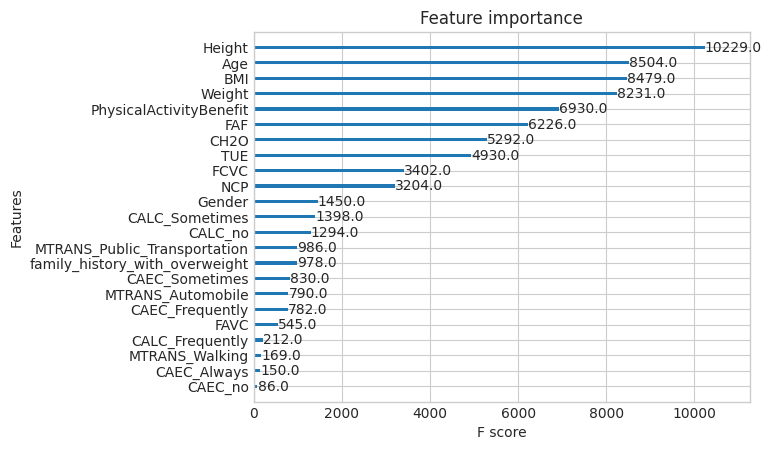

In [41]:
#Plot feature importance
from xgboost import plot_importance
plot_importance(xgbModel, importance_type='weight')
plt.show()

# <u><b>Playground Series S4E2 - Obesity Risk competition prediction</b></u>

In [42]:
#import dataset
dataset_test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
#Change index to id
dataset_test = dataset_test.set_index('id')

In [43]:
#Let's see the first 5 rows of our submission set
dataset_test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [44]:
dataset_test.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

In [45]:
#prepare dataset_test to be in correct format for our model
#1. Change columns to be of correct dtype 
for colName in dataset_test.select_dtypes(include=['O']).columns.tolist():
    if dataset_test[colName].nunique() == 2:
        dataset_test[colName] = label_encoder.fit_transform(dataset_test[colName])
    else:
        dataset_test[colName] = dataset_test[colName].astype('category')

dataset_test.dtypes

Gender                               int64
Age                                float64
Height                             float64
Weight                             float64
family_history_with_overweight       int64
FAVC                                 int64
FCVC                               float64
NCP                                float64
CAEC                              category
SMOKE                                int64
CH2O                               float64
SCC                                  int64
FAF                                float64
TUE                                float64
CALC                              category
MTRANS                            category
dtype: object

In [46]:
#2.1 Transform features
dataset_test['FAF'] = dataset_test.apply(lambda row: row['FAF']*1.1 if row['SCC']=='yes' else row['FAF'],axis=1)
dataset_test['FAF'] = dataset_test.apply(lambda row: row['FAF']*0.95 if row['SMOKE']=='yes' else row['FAF'],axis=1)
dataset_test['Age'] = boxcox(dataset_test['Age'],lmbda=boxcox_lambda_value_Age)
dataset_test['Weight'] = yeojohnson(dataset_test['Weight'],lmbda=yj_lambda_value_Weight)
#2.2 Add features
dataset_test['PhysicalActivityBenefit'] = dataset_test['FAF']-dataset_test['TUE']
dataset_test['BMI'] = dataset_test.Weight/(dataset_test.Height**2)
#3. Standardise the numeric features
dataset_test[numeric_features] = sc.transform(dataset_test[numeric_features])
#4. Encode categorical features
dataset_test = pd.get_dummies(data=dataset_test,columns=categorical_features, drop_first=False, dtype='int')
#5. Make sure columns are in the same order as our training dataset
training_set_col_order = dataset.columns.tolist()
dataset_test = dataset_test[training_set_col_order]
dataset_test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CH2O,FAF,...,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
id,,,,,,,,,,,,,,,,,,,,,
20758,1,0.803741,1.695675,1.212065,1,1,0.924049,0.338364,1.308584,-0.154127,...,1,0,0,1,0,0,0,0,1,0
20759,0,-0.389125,-1.148152,-0.806545,1,1,-0.836279,-2.497077,1.595165,0.017443,...,1,0,0,1,0,0,0,0,1,0
20760,0,0.664118,-0.651587,0.905346,1,1,1.039171,0.338364,0.973714,-1.169070,...,1,0,0,1,0,0,0,0,1,0
20761,1,-0.394799,-1.685011,0.628917,1,1,-0.836279,0.307045,1.244138,-1.056528,...,1,0,0,1,0,0,0,0,1,0
20762,0,0.664118,-0.834373,0.670027,1,1,1.039171,0.338364,1.025738,-1.169070,...,1,0,0,1,0,0,0,0,1,0


In [47]:
#Predictions on submission set
y_pred_submission = xgbModel.predict(dataset_test)

In [48]:
#Get predictions in expected submission file format
y_pred_submission_df = pd.DataFrame(y_pred_submission)
y_pred_submission_df = y_pred_submission_df.set_index(dataset_test.index.to_series())
y_pred_submission_df = y_pred_submission_df.set_axis(['NObeyesdad'], axis='columns')
#Decoding to original labels
for row, val in enumerate(y_pred_submission_df.values): 
    for key, value in label_mapping.items():
        if val == value:
            y_pred_submission_df.iloc[row,0] = key
y_pred_submission_df.head()

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III


In [49]:
#Create submission
y_pred_submission_df.to_csv("submission.csv")

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#35ee54;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
Thank you for reading through my notebook on Obesity Risk. I hope you enjoyed it and found it interesting☺️. I will also reply to any comments you have on this notebook. Have a good day!🚀
</p>
</div>